In [2]:
weather = sc.textFile("swift://ClimateDataForTutorial.spark/2015.csv")
weatherParse = weather.map(lambda line : line.split(","))
weatherSnow = weatherParse.filter(lambda x: x[2]=="SNOW")
weatherSnow.count()

2882070

In [4]:
from pyspark.sql import SQLContext, Row
from datetime import datetime

# instantiate SQLContext object
sqlContext = SQLContext(sc)
# Convert each line of snowWeather RDD into a Row object
snowRows= weatherSnow.map(lambda p: Row(station=p[0], month=datetime.strptime(p[1], '%Y%m%d').month, date=datetime.strptime(p[1], '%Y%m%d').day,metric=p[2], value=int(p[3])))
# Apply Row schema
snowSchema = sqlContext.createDataFrame(snowRows)
# Register 'snow2015' table with 5 columns: station, month, date, metric, and value
snowSchema.registerTempTable("snow2015")
sqlContext.cacheTable("snow2015")

In [5]:
snow_US10chey021 = sqlContext.sql("SELECT month, COUNT(*) AS snowdays FROM snow2015 WHERE station='US10chey021' GROUP BY month ORDER BY month").collect()

In [6]:
US10chey021_snowdays_y=[0] * 12
for row in snow_US10chey021:
    US10chey021_snowdays_y[row.month - 1]=row.snowdays
    
print US10chey021_snowdays_y

[31, 27, 31, 29, 29, 24, 24, 29, 16, 0, 0, 0]


In [7]:
snow_USW00094985 = sqlContext.sql("SELECT  month, COUNT(*) AS snowdays FROM snow2015 WHERE station='USW00094985' GROUP BY month ORDER BY month").collect()
USW00094985_snowdays_y=[0] * 12
for row in snow_USW00094985:
    USW00094985_snowdays_y[row.month -1]=row.snowdays
    
print USW00094985_snowdays_y

[31, 25, 30, 30, 30, 30, 31, 30, 18, 0, 0, 0]


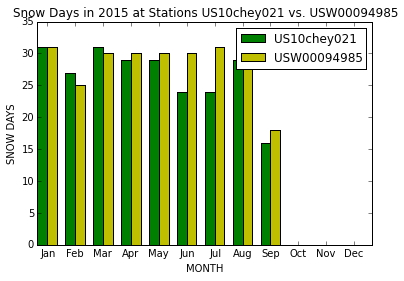

In [8]:
%matplotlib inline
import matplotlib
import numpy as np
import matplotlib.pyplot as plt

N=12
ind=np.arange(N)
width = 0.35
pUS10chey021 = plt.bar(ind, US10chey021_snowdays_y, width, color='g', label='US10chey021')
pUSW00094985 = plt.bar(ind+width, USW00094985_snowdays_y, width, color='y', label='USW00094985')

plt.ylabel('SNOW DAYS')
plt.xlabel('MONTH')
plt.title('Snow Days in 2015 at Stations US10chey021 vs. USW00094985')
plt.xticks(ind+width, ('Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'))
plt.legend()

plt.show()

In [9]:
snowStations = sqlContext.sql("SELECT  station, COUNT(*) AS snowdays FROM snow2015 WHERE station LIKE 'US%' GROUP BY station ORDER BY station LIMIT 100")

In [10]:
snowStations.head(5)

[Row(station=u'US10adam001', snowdays=58),
 Row(station=u'US10adam002', snowdays=132),
 Row(station=u'US10adam004', snowdays=254),
 Row(station=u'US10adam006', snowdays=28),
 Row(station=u'US10adam007', snowdays=25)]

In [11]:
sqlContext.registerDataFrameAsTable(snowStations, "snowdays_2015")

In [12]:
snowStations_new = sqlContext.sql("SELECT station, snowdays FROM snowdays_2015 ORDER BY snowdays DESC LIMIT 5").collect()
for row in snowStations_new:
    print row

Row(station=u'US10buff036', snowdays=259)
Row(station=u'US10ceda005', snowdays=254)
Row(station=u'US10adam004', snowdays=254)
Row(station=u'US10adam051', snowdays=252)
Row(station=u'US10adam032', snowdays=245)


In [13]:
snowdays_100 = sqlContext.sql("SELECT station, snowdays FROM snowdays_2015")
snowday_stations=snowdays_100.map(lambda x:  (x.snowdays,x.station)).reduceByKey(lambda x, y: x + ',' + y)
for snowday in snowday_stations.collect():
    print 'Snow days:' + str(snowday[0]) + ' Stations:' + str(snowday[1])

Snow days:1 Stations:US10bann007
Snow days:2 Stations:US10chas021
Snow days:259 Stations:US10buff036
Snow days:132 Stations:US10adam002
Snow days:5 Stations:US10bann005
Snow days:7 Stations:US10chas027
Snow days:8 Stations:US10cher009
Snow days:10 Stations:US10cher005,US10cher018
Snow days:13 Stations:US10chey008
Snow days:14 Stations:US10chas032
Snow days:15 Stations:US10chey009
Snow days:18 Stations:US10cher013
Snow days:131 Stations:US10cass010
Snow days:21 Stations:US10bann009,US10box_009
Snow days:22 Stations:US10adam012
Snow days:23 Stations:US10box_020,US10cher026
Snow days:24 Stations:US10box_007
Snow days:25 Stations:US10adam007
Snow days:26 Stations:US10adam035,US10chas013,US10chas019,US10chas035
Snow days:27 Stations:US10ceda001,US10chas033
Snow days:28 Stations:US10adam006
Snow days:29 Stations:US10adam013
Snow days:30 Stations:US10ceda020
Snow days:133 Stations:US10cass005
Snow days:32 Stations:US10adam017,US10adam029,US10ceda015
Snow days:33 Stations:US10adam024,US10ante0

In [14]:
# Save as parquet file
snowStations.saveAsParquetFile("swift://ClimateDataForTutorial.spark/snowStations.parquet")

In [16]:
parquetFile = sqlContext.parquetFile("swift://ClimateDataForTutorial.spark/snowStations.parquet")
parquetFile.registerTempTable("snow_from_parquet")

In [17]:
parquetFile.head(5)

[Row(station=u'US10adam001', snowdays=58),
 Row(station=u'US10adam002', snowdays=132),
 Row(station=u'US10adam004', snowdays=254),
 Row(station=u'US10adam006', snowdays=28),
 Row(station=u'US10adam007', snowdays=25)]